In [3]:
# imported necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [6]:
import sqlite3
con = sqlite3.connect("final.sqlite")

In [8]:
# Select data from table "Review"
cleaned_data = pd.read_sql_query("select * from Reviews", con)
cleaned_data.shape

(364171, 12)

In [118]:
# Sort data based on time
cleaned_data["Time"] = pd.to_datetime(cleaned_data["Time"], unit = "s")
cleaned_data = cleaned_data.sort_values(by = "Time")

In [119]:
# To look at each class count
cleaned_data["Score"].value_counts() 

positive    307061
negative     57110
Name: Score, dtype: int64

In [120]:
# Select first 100k data-points
final = cleaned_data.iloc[:100000,:]
final.shape

(100000, 12)

# TF-IDF

In [121]:
# Data
X = final["CleanedText"]
X.shape

(100000,)

In [122]:
# Featurization
tfidf = TfidfVectorizer(use_idf = True, max_df = 0.80)
feat = tfidf.fit_transform(X)
feat.shape

(100000, 37164)

In [123]:
# Standardization
std = StandardScaler(with_mean = False)
std_data = std.fit_transform(feat)
std_data

<100000x37164 sparse matrix of type '<class 'numpy.float64'>'
	with 3014548 stored elements in Compressed Sparse Row format>

In [124]:
# List of vocabulary
list(tfidf.vocabulary_.keys())[0:10]

['witti',
 'littl',
 'book',
 'make',
 'son',
 'laugh',
 'loud',
 'recit',
 'car',
 'drive']

In [125]:
# List of vocabulary values 
list(tfidf.vocabulary_.values())[0:10]

[36314, 18773, 3652, 19426, 30134, 18228, 19019, 26678, 4912, 9712]

In [126]:
# Get feature names from tfidf
features = tfidf.get_feature_names()
# feature weights based on idf score
coef = tfidf.idf_
# Store features with their idf score in a dataframe
coeff_df = pd.DataFrame({'Features' : features, 'Idf_score' : coef})
coeff_df = coeff_df.sort_values("Idf_score", ascending = True)[:2000]
print("shape of selected features :", coeff_df.shape)
print("Top 5 features :\n\n",coeff_df[0:10])

shape of selected features : (2000, 2)
Top 5 features :

       Features  Idf_score
32184     tast   2.187421
18615     like   2.209129
13668     good   2.325322
13999    great   2.375879
19037     love   2.394135
11983   flavor   2.460856
22801      one   2.490954
25582  product   2.516003
34754      use   2.554534
33521      tri   2.559420


In [127]:
# Calculate Co-Occurrence Matrix
# with windows size 1 in forward and backward pass
# https://stackoverflow.com/questions/41661801/python-calculate-the-co-occurrence-matrix?noredirect=1&lq=1
# https://cs224d.stanford.edu/lecture_notes/notes1.pdf
# just for sanity checks
import pandas as pd
import numpy as np
sentence = "I enjoy flying .", "I like NLP .", "I like deep learning ."
wrd = "I", "like", "enjoy", "deep", "learning", "NLP", "flying", "."
zero = np.zeros((len(wrd), len(wrd)))
df_zero = pd.DataFrame(zero, index = wrd, columns = wrd)
window = 1
for sent in sentence:
    word = sent.split(" ")
    for idx, dumb in enumerate(word):
            for j in range(max(idx-window,0),min(idx+window,len(word))):
                if (word[j] != word[idx]):
                        try:
                            df_zero.loc[word[idx], word[j]] += 1
                            df_zero.loc[word[j], word[idx]] += 1
                        except:
                            pass
print(df_zero)

            I  like  enjoy  deep  learning  NLP  flying    .
I         0.0   2.0    1.0   0.0       0.0  0.0     0.0  0.0
like      2.0   0.0    0.0   1.0       0.0  1.0     0.0  0.0
enjoy     1.0   0.0    0.0   0.0       0.0  0.0     1.0  0.0
deep      0.0   1.0    0.0   0.0       1.0  0.0     0.0  0.0
learning  0.0   0.0    0.0   1.0       0.0  0.0     0.0  1.0
NLP       0.0   1.0    0.0   0.0       0.0  0.0     0.0  1.0
flying    0.0   0.0    1.0   0.0       0.0  0.0     0.0  1.0
.         0.0   0.0    0.0   0.0       1.0  1.0     1.0  0.0


In [128]:
# https://cs224d.stanford.edu/lecture_notes/notes1.pdf
# co-occurence matrix
co_occurence_matrix = np.zeros((len(coeff_df), len(coeff_df)))
print(co_occurence_matrix.shape)
df = pd.DataFrame(co_occurence_matrix, index = coeff_df["Features"], columns = coeff_df["Features"])
df.shape

(2000, 2000)


(2000, 2000)

In [130]:
# Calculate Co-Occurrence Matrix 
# with windows size 4 in forward and backward pass
%time
window_size = 4
for sent in final["CleanedText"].str.decode("utf-8"):
    word = sent.split(" ")
    for i, d in enumerate(word):
        for j in range(max(i - window_size, 0), min(i + window_size, len(word))):
            if (word[i] != word[j]):
                    try:
                        df.loc[word[i], word[j]] += 1
                        df.loc[word[j], word[i]] += 1
                    except:
                        pass

Wall time: 0 ns


In [131]:
df.head()

Features,tast,like,good,great,love,flavor,one,product,use,tri,...,schedul,remark,cancer,coast,tax,game,crash,twin,buffalo,reliabl
Features,,,,,,,,,,,,,,,,,,,,,
tast,0.0,37322.0,25502.0,24136.0,8760.0,11942.0,8468.0,8142.0,6460.0,6564.0,...,10.0,80.0,10.0,10.0,8.0,22.0,26.0,72.0,132.0,10.0
like,37322.0,0.0,10226.0,6526.0,6550.0,16318.0,10616.0,8310.0,6932.0,8860.0,...,16.0,52.0,24.0,24.0,40.0,64.0,96.0,38.0,96.0,22.0
good,25502.0,10226.0,0.0,6296.0,4938.0,11548.0,7076.0,9508.0,5268.0,5384.0,...,36.0,22.0,22.0,12.0,34.0,28.0,30.0,40.0,36.0,98.0
great,24136.0,6526.0,6296.0,0.0,7386.0,11642.0,4478.0,14842.0,5736.0,3798.0,...,40.0,10.0,12.0,8.0,52.0,48.0,52.0,38.0,80.0,18.0
love,8760.0,6550.0,4938.0,7386.0,0.0,8674.0,5868.0,7728.0,4532.0,5824.0,...,18.0,44.0,8.0,22.0,8.0,36.0,6.0,110.0,54.0,22.0


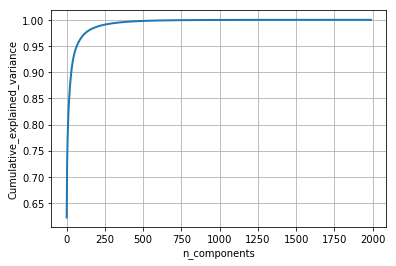

In [132]:
# TrucatedSVD
from sklearn.decomposition import TruncatedSVD
ts = TruncatedSVD(n_components = 1990)
ts_data = ts.fit_transform(df)

percentage_var_explained = ts.explained_variance_ / np.sum(ts.explained_variance_)

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth = 2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

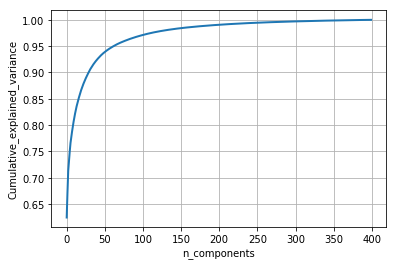

In [133]:
# TrucatedSVD
from sklearn.decomposition import TruncatedSVD
ts = TruncatedSVD(n_components = 400)
ts_data = ts.fit_transform(df)

percentage_var_explained = ts.explained_variance_ / np.sum(ts.explained_variance_)

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth = 2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [45]:
# Elbow method to find K 
def find_optimal_k(data):
    loss = []
    k = list(range(2, 15, 2))
    for noc in k:
        model = KMeans(n_clusters = noc)
        model.fit(data)
        loss.append(model.inertia_)
    plt.plot(k, loss, "-o")
    plt.title("Elbow method to choose k")
    plt.xlabel("K")
    plt.ylabel("Loss")
    plt.show()

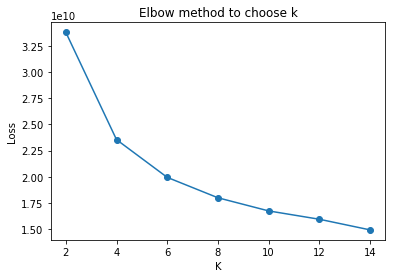

In [135]:
# Find best k using elbow method
find_optimal_k(ts_data)

In [136]:
# After applying truncated svd store data into dataframe
df = pd.DataFrame(ts_data)

In [137]:
# Data shape
df.shape

(2000, 400)

In [138]:
# K-means clustering
clf = KMeans(n_clusters = 10)
clf.fit(ts_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [139]:
# Assign each data-points with its correspondincg label
df["Cluster_labels"] = clf.labels_
df["Words"] = coeff_df["Features"].values     
df.head()     

,0,1,2,3,4,5,6,7,8,9,...,392,393,394,395,396,397,398,399,Cluster_labels,Words
0,59881.420757,32586.176584,-12852.900072,-4989.758557,-5965.097360,6087.051627,1787.695759,-2569.253037,895.912907,-404.167950,...,3.574520,7.050470,0.234949,5.858875,-0.076177,17.163580,1.907761,-6.409253,3,tast
1,56804.037960,-26060.367561,-11055.002907,-1899.896410,-4484.283116,2338.571190,4347.055621,9223.256753,-1172.303491,-2416.901577,...,-2.132498,-1.922208,-5.649539,0.680607,5.449373,-5.179021,-9.216956,0.458119,8,like
2,44222.883736,-15322.048994,-3663.998768,-43.326509,-4643.259489,3653.334422,-953.476768,-3544.583558,731.785518,-1379.955210,...,-8.072728,-0.626688,-3.853665,-20.991729,-5.457099,9.928424,5.097768,-1.741863,8,good
3,40025.240503,-16597.594326,-358.912092,557.813033,-4969.741152,3658.977812,-4811.804012,-7868.129629,2021.006836,778.055489,...,9.470369,6.580582,10.790599,24.200319,4.769942,5.943151,12.189425,-17.862826,8,great
4,32425.632346,-3387.354140,940.949001,-5807.379995,-218.385331,-3628.964031,2593.075700,-96.907668,1553.262239,-1244.415621,...,-9.301905,2.358294,7.005368,1.129697,-8.372018,-4.318320,-8.294871,-8.970303,4,love


In [140]:
# Plotting word cloud
def plot_word_cloud(txt):
    # store each word from review
    cloud = " ".join(word for word in txt)
    # Remove duplicate words
    stopwords = set(STOPWORDS) 
    # call built-in method WordCloud for creating an object for drawing a word cloud 
    wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud)
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 8))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off") 
    plt.title("World cloud of top words")
    plt.tight_layout(pad = 0)
    plt.show()

total number of word in cluster 0 is 358


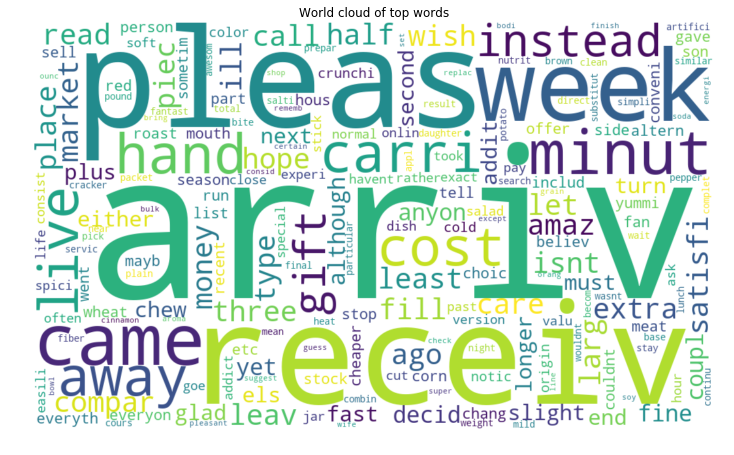

total number of word in cluster 1 is 17


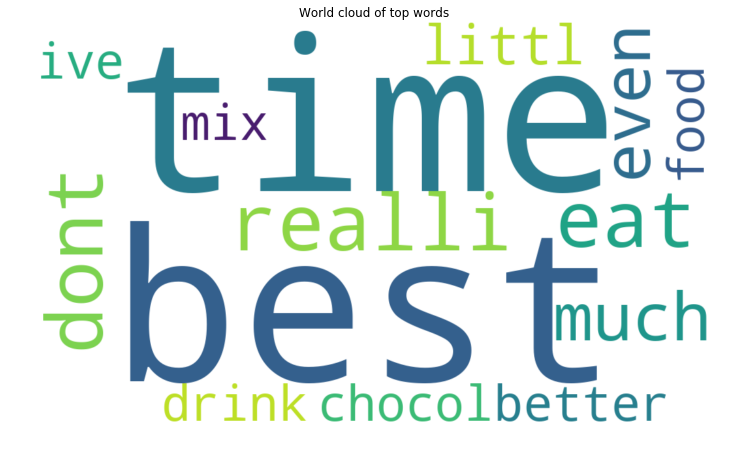

total number of word in cluster 2 is 149


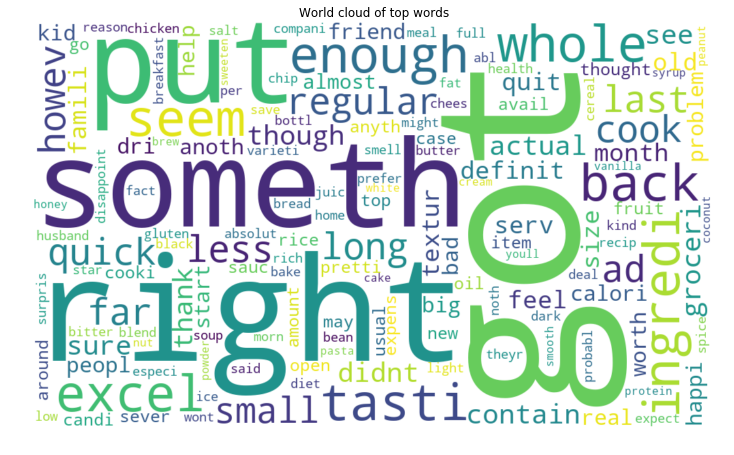

total number of word in cluster 3 is 1


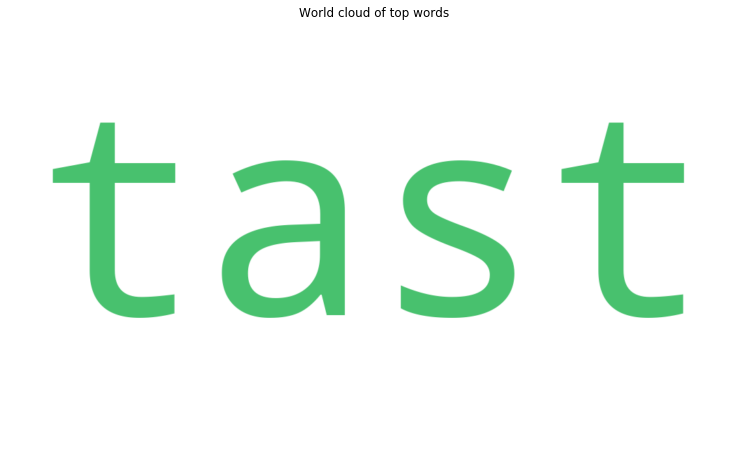

total number of word in cluster 4 is 7


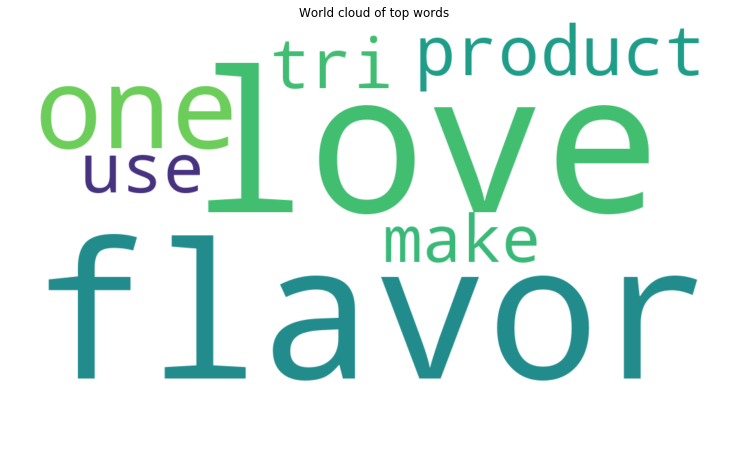

total number of word in cluster 5 is 75


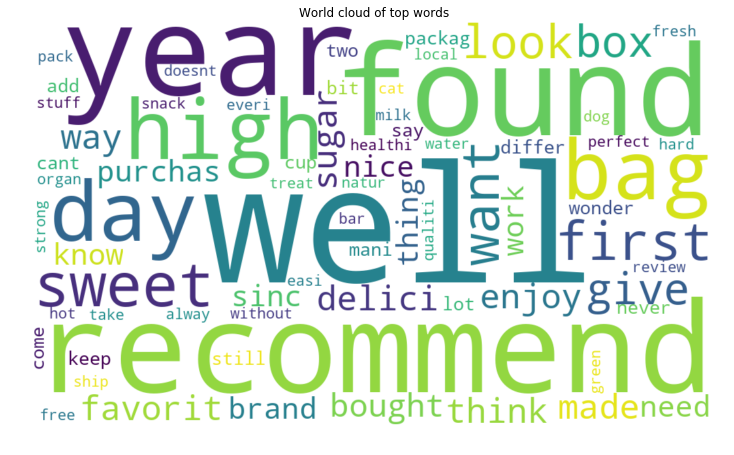

total number of word in cluster 6 is 1382


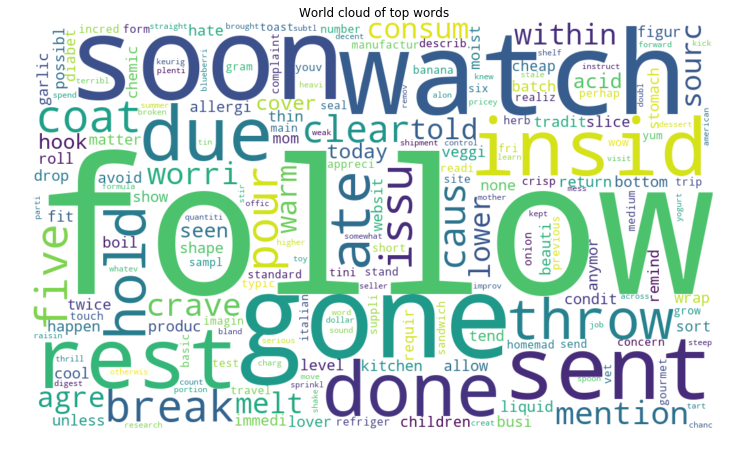

total number of word in cluster 7 is 2


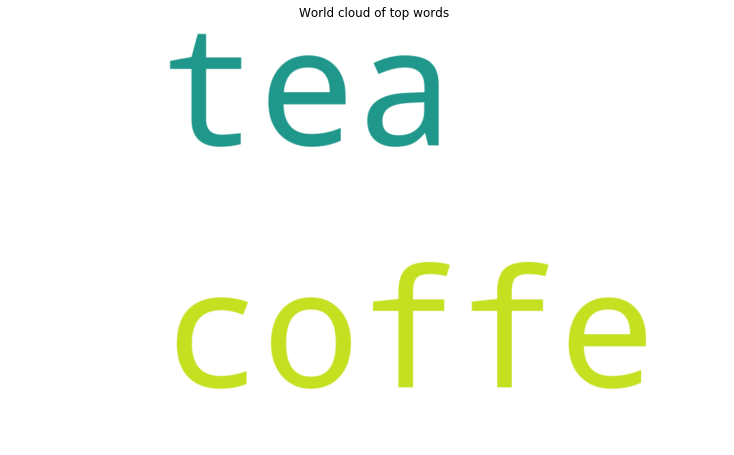

total number of word in cluster 8 is 3


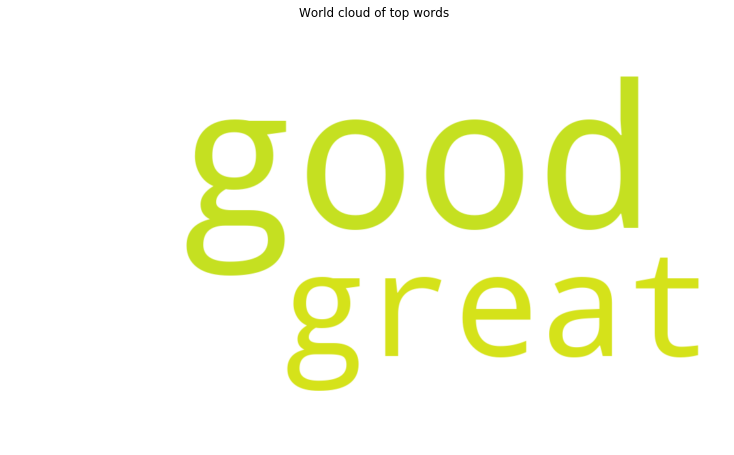

total number of word in cluster 9 is 6


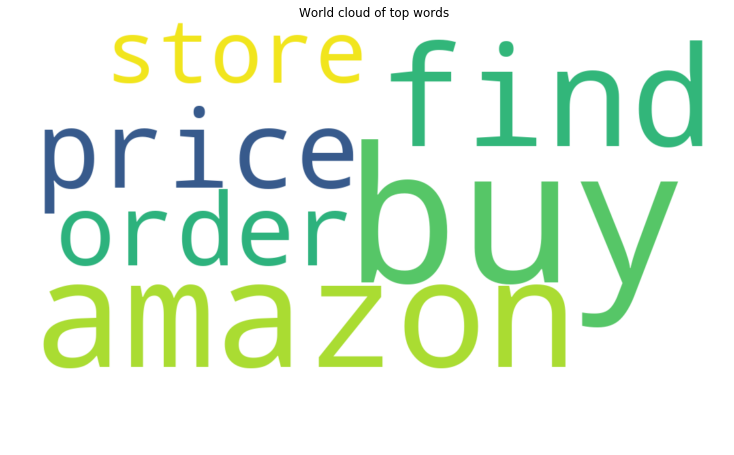

In [141]:
# print word cloud of each cluster
for i in range(clf.n_clusters):
    l = list()
    # Groups each label
    label = df.groupby(["Cluster_labels"]).groups[i]
    # store each word from a particular label in a list and pass it word cloud method
    for j in range(len(label)):
        l.append(df.loc[label[j]]["Words"])
    print("total number of word in cluster {} is {}".format(i, len(label)))    
    plot_word_cloud(l)

In [142]:
# Calculate cosine similarity
from sklearn.metrics import pairwise_distances
def cosine_similarity(word_index, total_results):
    # calculate pairwise distances from given word
    # The smaller the distance, the more similar the word
    dist = pairwise_distances(ts_data, ts_data[word_index:word_index + 1,:])
    # Store index of the distances
    indices = np.argsort(dist.flatten())[0:total_results]
    # Sort distances 
    pdist = np.sort(dist.flatten())[0:total_results]
    # put indices at particular index of dataframe
    df_indices = list(df.index[indices])
    print("Most_Similar Words \t Distances")
    # Loop through indices and find match
    for i in range(len(indices)): 
        if indices[i] == df.index[indices[i]]:
            print(df.Words.loc[indices[i]], "\t\t\t", dist[indices[i]])

In [143]:
# given index of a word
# find how similar words are from this index word
cosine_similarity(119, 7)

Most_Similar Words 	 Distances
less 			 [0.]
howev 			 [3790.6562839]
usual 			 [4159.61481047]
almost 			 [4312.60419288]
may 			 [4368.2622305]
that 			 [4445.00637807]
quit 			 [4514.89945316]


In [149]:
# given index of a word
# find how similar words are from this index word
cosine_similarity(56, 7)

Most_Similar Words 	 Distances
purchas 			 [0.]
bought 			 [4318.24361161]
alway 			 [5893.76988435]
avail 			 [5982.35921588]
got 			 [6058.71825709]
see 			 [6166.76616384]
howev 			 [6194.29645257]


**Conclusions** <br>
1. We have used 100k data-points and applied tfidf on top of it to vectorize text data and then selected top 2k features based on idf score.
2. We have calculated co-occurence matrix to store count of how often a features occur together in a context and then used truncatedsvd.
3. Used k-means clustering to group similar features together.
4. we calculated cosine similarity to get which words are more similar to a given word.